In [175]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [176]:
'''Import the e-commerce csv to a pandas df'''
# data = pd.read_csv('/kaggle/input/ecommerce-data/data.csv',encoding= 'ISO-8859-1')
data = pd.read_csv('data.csv',encoding= 'ISO-8859-1')
global separator
separator = '\n***********************************************************************\n'

In [177]:
'''Basic info and describe analysis over the dataset'''
print(separator)
print(data.info())
print(separator)
print(data.describe())
print(separator)
print(data.head())
print(separator)
print(data.memory_usage(deep=True))
print(separator)


***********************************************************************

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None

***********************************************************************

            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12

In [178]:
'''Let's perform some memory optimisation by making Country, StockCode and Description as categorical columns.'''

data["Country"] = data["Country"].astype("category")
data["StockCode"] = data["StockCode"].astype("category")
data["Description"] = data["Description"].astype("category")
print(separator)
print(data.memory_usage(deep=True))
print(separator)


***********************************************************************

Index               128
InvoiceNo      34149558
StockCode       1501181
Description     1600709
Quantity        4335272
InvoiceDate    39006782
UnitPrice       4335272
CustomerID      4335272
Country          545665
dtype: int64

***********************************************************************



Now that's a lot better!! :D

This is an e-commerce orders history data set so it be 'should' safe to assume that InvoiceNo a depictor of total number of invoices issued/orders placed/entries in the data. 
There are total 541909 non-null entries.
Description(540455) and CustomerID(406829) has some missing values.
Description is a meta-data column and we may assume that neither it's values nor does some of it being missing shouldn't affect our EDA. Nonetheless we shall explore possibilites to ignore/impute it.
CustomerID values missing is an interesting find, seems like a data-entry limitation by BSS personnel. Having said that imputation for these missing values
for CustomerID seems tough and not fruitful since it's supposed to be a unique data for a unique customer. Having said that, we shall revisit this point after some analysis. We never know what pattern we may find. ;)

From the describe() we see that we have 3 numerical columns: Quantity, UnitPrice and CustomerID. This was expected.
The spread is vast for all 3, since means and medians are far apart saying these data points aren't normally distributed.
Quanitiy and UnitPrice have min in -ve, that's interesting fact. It mostly should refer to the 'return orders' for which the company has to pay out cash from it's pocket to that customer/customerID.

In [179]:
'''Let's find out the missing(isnull) absolute and % of data.'''

print(data.isnull().sum().sort_values(ascending=False))
print(separator)
print(round (data.isnull().sum().sort_values(ascending=False)/len(data)*100,2))

CustomerID     135080
Description      1454
Country             0
UnitPrice           0
InvoiceDate         0
Quantity            0
StockCode           0
InvoiceNo           0
dtype: int64

***********************************************************************

CustomerID     24.93
Description     0.27
Country         0.00
UnitPrice       0.00
InvoiceDate     0.00
Quantity        0.00
StockCode       0.00
InvoiceNo       0.00
dtype: float64


Description has .27% missing data, I'm going to let it be and not do anything about it for now. Later if we find it co relating to some other column we may think again.

CustomerID has close to 25% missing data, we need to do something about it.

Let's dig deeper.

In [180]:
print(data[["InvoiceNo", "Country"]].groupby('Country').count().sort_values("InvoiceNo", ascending=False))

                      InvoiceNo
Country                        
United Kingdom           495478
Germany                    9495
France                     8557
EIRE                       8196
Spain                      2533
Netherlands                2371
Belgium                    2069
Switzerland                2002
Portugal                   1519
Australia                  1259
Norway                     1086
Italy                       803
Channel Islands             758
Finland                     695
Cyprus                      622
Sweden                      462
Unspecified                 446
Austria                     401
Denmark                     389
Japan                       358
Poland                      341
Israel                      297
USA                         291
Hong Kong                   288
Singapore                   229
Iceland                     182
Canada                      151
Greece                      146
Malta                       127
United A

It's a UK based ecommerce website, and their sales/transactions data tell the same story. Highest number in the UK, followed by the EU and then the rest of the world. OK, this confirms our intuition. And the periods of transaction were in 1st Dec 2010 to 9th Dec 2011.

AxesSubplot(0.125,0.125;0.775x0.755)


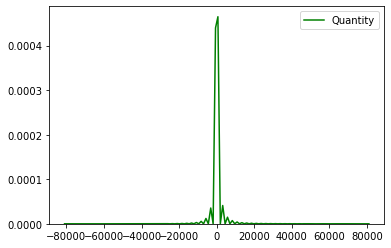

In [181]:
print(sns.kdeplot(data['Quantity'], color="green"))

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


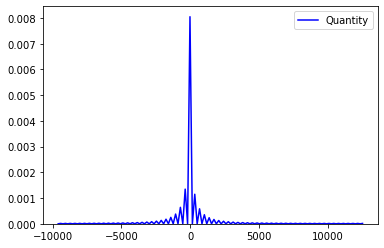

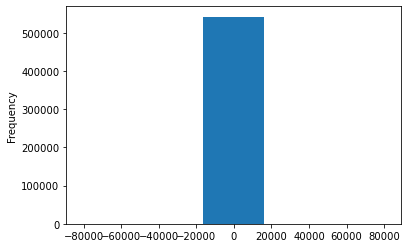

In [182]:
print(sns.kdeplot(data['Quantity'], clip=(-20000, 20000), color="blue"))
plt.figure()
print(data['Quantity'].plot(kind='hist',bins=5))

The Quantity is mainly available across the -20000,20000 range.

CustomerID     135080
Description      1454

CustomerID     24.93%
Description     0.27%

These are the NA values in our data set. Let's drop them, since description is low in % and it doesn't matter much so we may care not to produce it. CustomerID on the other hand is not possible to find out since there appears to be no co direct relation with other column(s).

In [183]:
data.dropna(inplace=True)
data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Perfect, now we have dropped the NA rows. Let's look back at the basic info once again on the new df.

In [184]:
'''Basic info and describe analysis over the dataset'''
print(data.info())
print(separator)
print(data.describe())
print(separator)
print(data.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   InvoiceNo    406829 non-null  object  
 1   StockCode    406829 non-null  category
 2   Description  406829 non-null  category
 3   Quantity     406829 non-null  int64   
 4   InvoiceDate  406829 non-null  object  
 5   UnitPrice    406829 non-null  float64 
 6   CustomerID   406829 non-null  float64 
 7   Country      406829 non-null  category
dtypes: category(3), float64(2), int64(1), object(2)
memory usage: 20.9+ MB
None

***********************************************************************

            Quantity      UnitPrice     CustomerID
count  406829.000000  406829.000000  406829.000000
mean       12.061303       3.460471   15287.690570
std       248.693370      69.315162    1713.600303
min    -80995.000000       0.000000   12346.000000
25%         2.000000       1.250000   13

In [185]:
data[(data['Quantity']<=0) | (data['UnitPrice']<0)].count()

InvoiceNo      8905
StockCode      8905
Description    8905
Quantity       8905
InvoiceDate    8905
UnitPrice      8905
CustomerID     8905
Country        8905
dtype: int64

8905 rows have Quantity in negative or UnitPrice negative. This might mean they are return orders, or we are not sure of the reason why they are so. 9k out of 5L records, we may trim it out and be fine with the data we will have left. Let's proceed that way.

In [186]:
data=data[data['Quantity']>0]
data=data[data['UnitPrice']>=0]

In [187]:
print(data.shape)

(397924, 8)


In [188]:
data.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom

Let's add a column to find the total Amount or price of the invoice/order. That would be Quantity * UnitPrice

In [189]:
data['TotalAmount']=data['Quantity']*data['UnitPrice']
data.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  TotalAmount  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom        15.30  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom        20.34  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom        22.00  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom        20.34  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom        20.34

Let's find the largest amount order. 

In [190]:
data[data['TotalAmount']==data['TotalAmount'].max()]

InvoiceNo StockCode                  Description  Quantity  \
540421    581483     23843  PAPER CRAFT , LITTLE BIRDIE     80995   

           InvoiceDate  UnitPrice  CustomerID         Country  TotalAmount  
540421  12/9/2011 9:15       2.08     16446.0  United Kingdom     168469.6

So the invoice num 581483 was the largest order received amounting to 168469.6. Order was placed on 12-9-2011 by a UK customer(16446) with PAPER CRAFT , LITTLE BIRDIE description.

In [191]:
data[data['CustomerID']==16446.0].sort_values(by='InvoiceDate', ascending=False)

InvoiceNo StockCode                  Description  Quantity  \
194354    553573     22980       PANTRY SCRUBBING BRUSH         1   
194355    553573     22982          PANTRY PASTRY BRUSH         1   
540421    581483     23843  PAPER CRAFT , LITTLE BIRDIE     80995   

           InvoiceDate  UnitPrice  CustomerID         Country  TotalAmount  
194354  5/18/2011 9:52       1.65     16446.0  United Kingdom         1.65  
194355  5/18/2011 9:52       1.25     16446.0  United Kingdom         1.25  
540421  12/9/2011 9:15       2.08     16446.0  United Kingdom    168469.60

Besides that huge order, this particular customer hasn't placed any significant orders.

Now, let's do some operation on the InvoiceDate column to help us study the dataset more.

In [192]:
'''Convert InvoicdeDate to datetime'''
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

'''Grouping the data based on months to get a feel of the monthly sales data'''
data_new = data.groupby(pd.Grouper(key='InvoiceDate',freq='M')).sum()
data_new.reset_index(level=0, inplace=True)
data_new

InvoiceDate  Quantity   UnitPrice   CustomerID  TotalAmount
0   2010-12-31    312280   81935.610  406240953.0   572713.890
1   2011-01-31    349147   66964.990  321904509.0   569445.040
2   2011-02-28    265638   63185.760  305225091.0   447137.350
3   2011-03-31    348544   88563.100  412680258.0   595500.760
4   2011-04-30    292225   79005.481  345952584.0   469200.361
5   2011-05-31    373685  102128.280  431158808.0   678594.560
6   2011-06-30    363699   85274.730  416663110.0   661213.690
7   2011-07-31    369432   75919.901  410703863.0   600091.011
8   2011-08-31    398938   79423.830  412144474.0   645343.900
9   2011-09-30    544899  119053.062  610894038.0   952838.382
10  2011-10-31    593908  165849.980  755924156.0  1039318.790
11  2011-11-30    681888  185522.460  991489169.0  1161817.380
12  2011-12-31    287413   47173.430  264994057.0   518192.790

Let's plot it out to get a better visual representation.

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


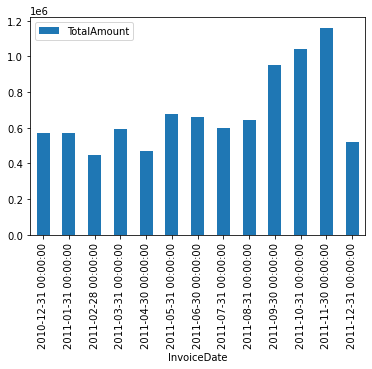

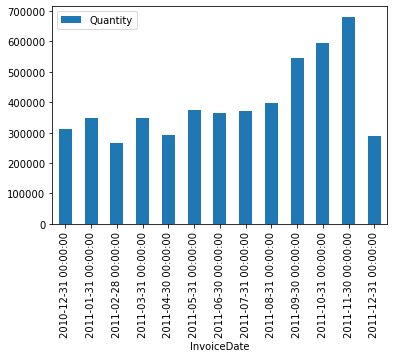

In [193]:
print(data_new.plot(x='InvoiceDate', y='TotalAmount',kind='bar'))
print(data_new.plot(x='InvoiceDate', y='Quantity',kind='bar'))

Thus, we conclude that Nov-2011 resulted in the highest sales both by TotalAmount and Quantity(this may be the case because of Christmas Shopping? ;) ), while Feb-2011 was the worst in terms of sales and the last quarter of the year was best among the 2011 quarters.

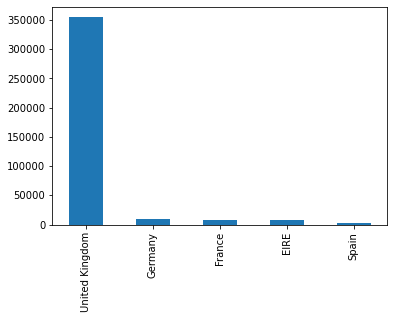

In [194]:
'''Top 5 countries sales count wise in the cleaned up data.'''
data.Country.value_counts().head().plot(kind='bar')

           Country   TotalAmount
36  United Kingdom  7.308392e+06
24     Netherlands  2.854463e+05
10            EIRE  2.655459e+05
14         Germany  2.288671e+05
13          France  2.090240e+05
AxesSubplot(0.125,0.125;0.775x0.755)


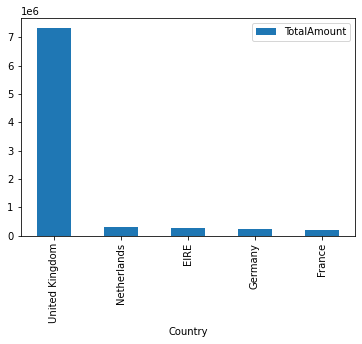

In [195]:
'''Top 5 countries Total Gross Amount sales wise.'''
data_temp = data.groupby(['Country'])['TotalAmount'].agg('sum').reset_index().sort_values(by=['TotalAmount'],ascending=False).head()
print(data_temp)
print(data_temp.plot(x='Country', y='TotalAmount',kind='bar'))

Let's check for the top 5 Order descriptions in terms of highest number of invoices against it.

In [196]:
data.groupby(['Description']).size().reset_index(name='counts').sort_values(by=['counts'],ascending=False).head()

Description  counts
3918  WHITE HANGING HEART T-LIGHT HOLDER    2028
2915            REGENCY CAKESTAND 3 TIER    1724
1866             JUMBO BAG RED RETROSPOT    1618
244        ASSORTED COLOUR BIRD ORNAMENT    1408
2471                       PARTY BUNTING    1397

# EDA conclusion:-

1. Top 5 countries in terms of highest counts of sale/invoices are: UK, Germany, France, Ireland, Spain.
2. Top 5 countries in terms of Total Gross Amount sales are: UK, Netherlands, Ireland, Germany, France.
3. The data had negative quantity/unit price, those might have been return orders. But anyways we have ignored those ones from our list.
4. Invoice num 581483 was the largest single order received amounting to 168469.6. Order was placed on 12-9-2011 by a UK customer(16446) with PAPER CRAFT , LITTLE BIRDIE description.
5. Nov-2011 resulted in the highest sales both by TotalAmount and Quantity(this may be the case because of Christmas Shopping? ;) ), while Feb-2011 was the worst in terms of sales and the last quarter of the year was best among the 2011 quarters.
6. 'WHITE HANGING HEART T-LIGHT HOLDER' was the top Order descriptions in terms of highest number of invoices against it.